In [61]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd

from lib.model import FNO1d
from lib.utils import relative_l2_error, calculate_errors
from lib.dataset import PDEDatasetAll2All

In [62]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [63]:
torch.manual_seed(0)
np.random.seed(0)

In [64]:
DEVICE = "cpu"

In [65]:
modes = 16
width = 64
layers = 4
fno = FNO1d(modes, width, layers).to(DEVICE)  # model
fno.load_state_dict(torch.load("models/tfno_model.pth", weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [66]:
time_pairs = [(0, 1), (0, 2), (0, 3), (0, 4)]
dataset = (
    PDEDatasetAll2All(
        "data/test_allen_cahn_fourier.npz", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_gmm.npz", device=DEVICE, time_pairs=time_pairs
    )
    + PDEDatasetAll2All(
        "data/test_allen_cahn_piecewise.npz", device=DEVICE, time_pairs=time_pairs
    )
)

errors, test_relative_l2 = calculate_errors(fno, dataset)
print(rf"Test Relative L2 error: {test_relative_l2}")

100%|██████████| 57/57 [00:01<00:00, 29.83it/s]

Test Relative L2 error: 0.01997905017601119


In [80]:
time_pairs = [(0, 4)]
dataset_fourier = PDEDatasetAll2All(
    "data/test_allen_cahn_fourier.npz", device=DEVICE, time_pairs=time_pairs
)


errors_fourier, test_fourier_relative_l2 = calculate_errors(fno, dataset_fourier)
print(rf"Test Relative L2 error: {test_fourier_relative_l2}")

100%|██████████| 5/5 [00:00<00:00, 28.74it/s]

Test Relative L2 error: 0.024658329089482626


In [81]:
time_pairs = [(0, 4)]
dataset_gmm = PDEDatasetAll2All(
    "data/test_allen_cahn_gmm.npz", device=DEVICE, time_pairs=time_pairs
)

errors_gmm, test_gmm_relative_l2 = calculate_errors(fno, dataset_gmm)
print(rf"Test Relative L2 error: {test_gmm_relative_l2}")

100%|██████████| 5/5 [00:00<00:00, 28.87it/s]

Test Relative L2 error: 0.015419368545214335


In [82]:
time_pairs = [(0, 4)]
dataset_piecewise = PDEDatasetAll2All(
    "data/test_allen_cahn_piecewise.npz", device=DEVICE, time_pairs=time_pairs
)

errors_piecewise, test_piecewise_relative_l2 = calculate_errors(fno, dataset_piecewise)
print(rf"Test Relative L2 error: {test_piecewise_relative_l2}")

100%|██████████| 5/5 [00:00<00:00, 30.02it/s]

Test Relative L2 error: 0.021486968199412027


In [70]:
errors_piecewise

,dt,l2_error,epsilon
0,0.10,0.003395,0.10
1,0.10,0.007985,0.10
2,0.02,0.006231,0.02
3,0.02,0.005189,0.02
4,0.02,0.006277,0.02
...,...,...,...
295,0.05,0.007306,0.05
296,0.05,0.322734,0.05
297,0.05,0.011189,0.05
298,0.05,0.008528,0.05


In [71]:
errors_gmm

,dt,l2_error,epsilon
0,0.10,0.016075,0.10
1,0.02,0.006587,0.02
2,0.05,0.007908,0.05
3,0.10,0.014242,0.10
4,0.05,0.258437,0.05
...,...,...,...
295,0.10,0.048537,0.10
296,0.05,0.005469,0.05
297,0.05,0.004439,0.05
298,0.10,0.007821,0.10


In [72]:
df = pd.DataFrame(errors)
df["epsilon_s"] = df["epsilon"].apply(lambda x: f"{x:.3f}")
df["dt_s"] = df["dt"].apply(lambda x: f"{x:.3f}")
# sort by dt
df = df.sort_values(by="dt")
df

,dt,l2_error,epsilon,epsilon_s,dt_s
354,0.005,0.004565,0.02,0.020,0.005
3136,0.005,0.048936,0.02,0.020,0.005
342,0.005,0.006318,0.02,0.020,0.005
3165,0.005,0.006146,0.02,0.020,0.005
3182,0.005,0.005755,0.02,0.020,0.005
...,...,...,...,...,...
450,0.100,0.015072,0.10,0.100,0.100
2,0.100,0.012229,0.10,0.100,0.100
32,0.100,0.010172,0.10,0.100,0.100
3598,0.100,0.006075,0.10,0.100,0.100


In [73]:
# calculate mean error for each dt
mean_error_dt = df.groupby(pd.cut(df["dt"], bins=20), observed=True)["l2_error"].mean().reset_index()
mean_error_dt["dt"] = mean_error_dt["dt"].apply(lambda x: f"{x.mid:.3f}")
mean_error_dt

,dt,l2_error
0,0.007,0.017010
1,0.012,0.015950
2,0.017,0.015815
3,0.022,0.017181
4,0.026,0.021212
5,0.036,0.016603
6,0.050,0.023256
7,0.074,0.027753
8,0.098,0.024549


<Axes: xlabel='dt', ylabel='l2_error'>

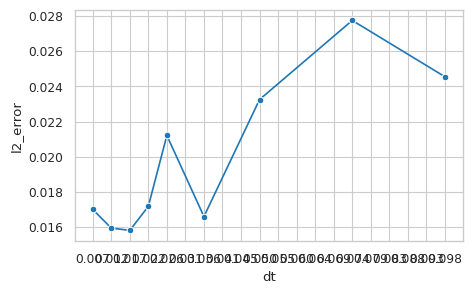

In [74]:
# plot the error
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=mean_error_dt, x="dt", y="l2_error", ax=ax, marker="o")

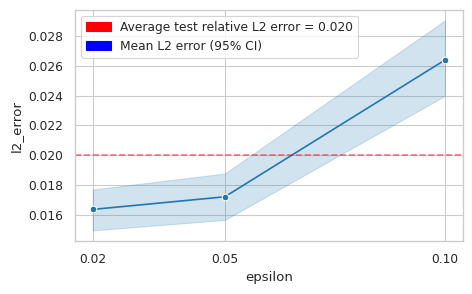

In [75]:
# plot mean_error_eps
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=df, x="epsilon", y="l2_error", ax=ax, marker="o")
# set ticks to epsilon
ax.set_xticks(df["epsilon"].unique())

plt.axhline(y=test_relative_l2, color="r", linestyle="--", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Average test relative L2 error = {test_relative_l2:.3f}"),
        Patch(facecolor="b", edgecolor="b", label="Mean L2 error (95% CI)"),
    ]
)
plt.savefig("figures/test_error_vs_epsilon.png", dpi=300)
plt.show()

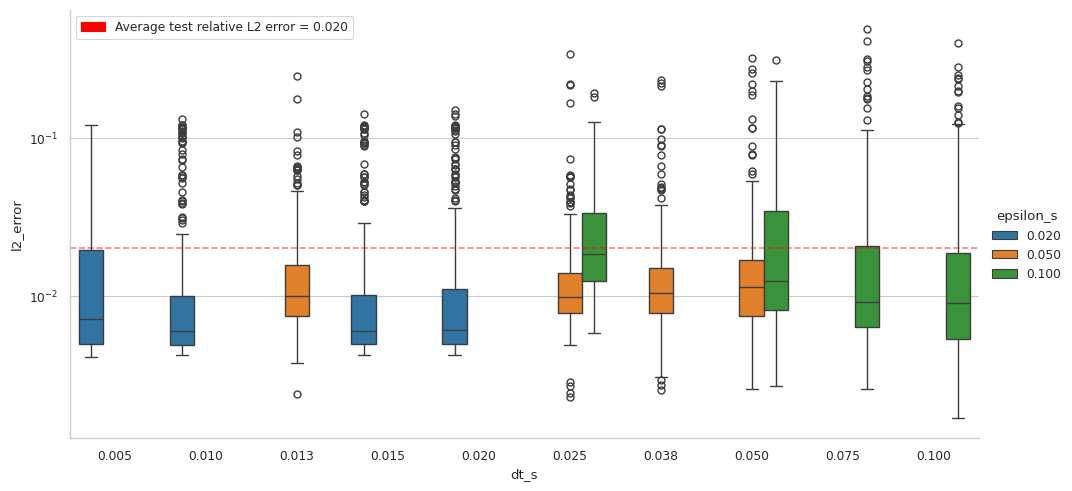

In [76]:
sns.catplot(
    data=df,
    x="dt_s",
    y="l2_error",
    log_scale=True,
    hue="epsilon_s",
    height=5,
    aspect=2,
    kind="box",
)
# draw a horizontal line at the OOD relative L2 error
plt.axhline(y=test_relative_l2, color="r", linestyle="--", alpha=0.5)

plt.legend(
    handles=[
        Patch(facecolor="r", edgecolor="r", label=f"Average test relative L2 error = {test_relative_l2:.3f}"),
    ]
)


In [77]:
BATCH_SIZE = 5
sampler = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

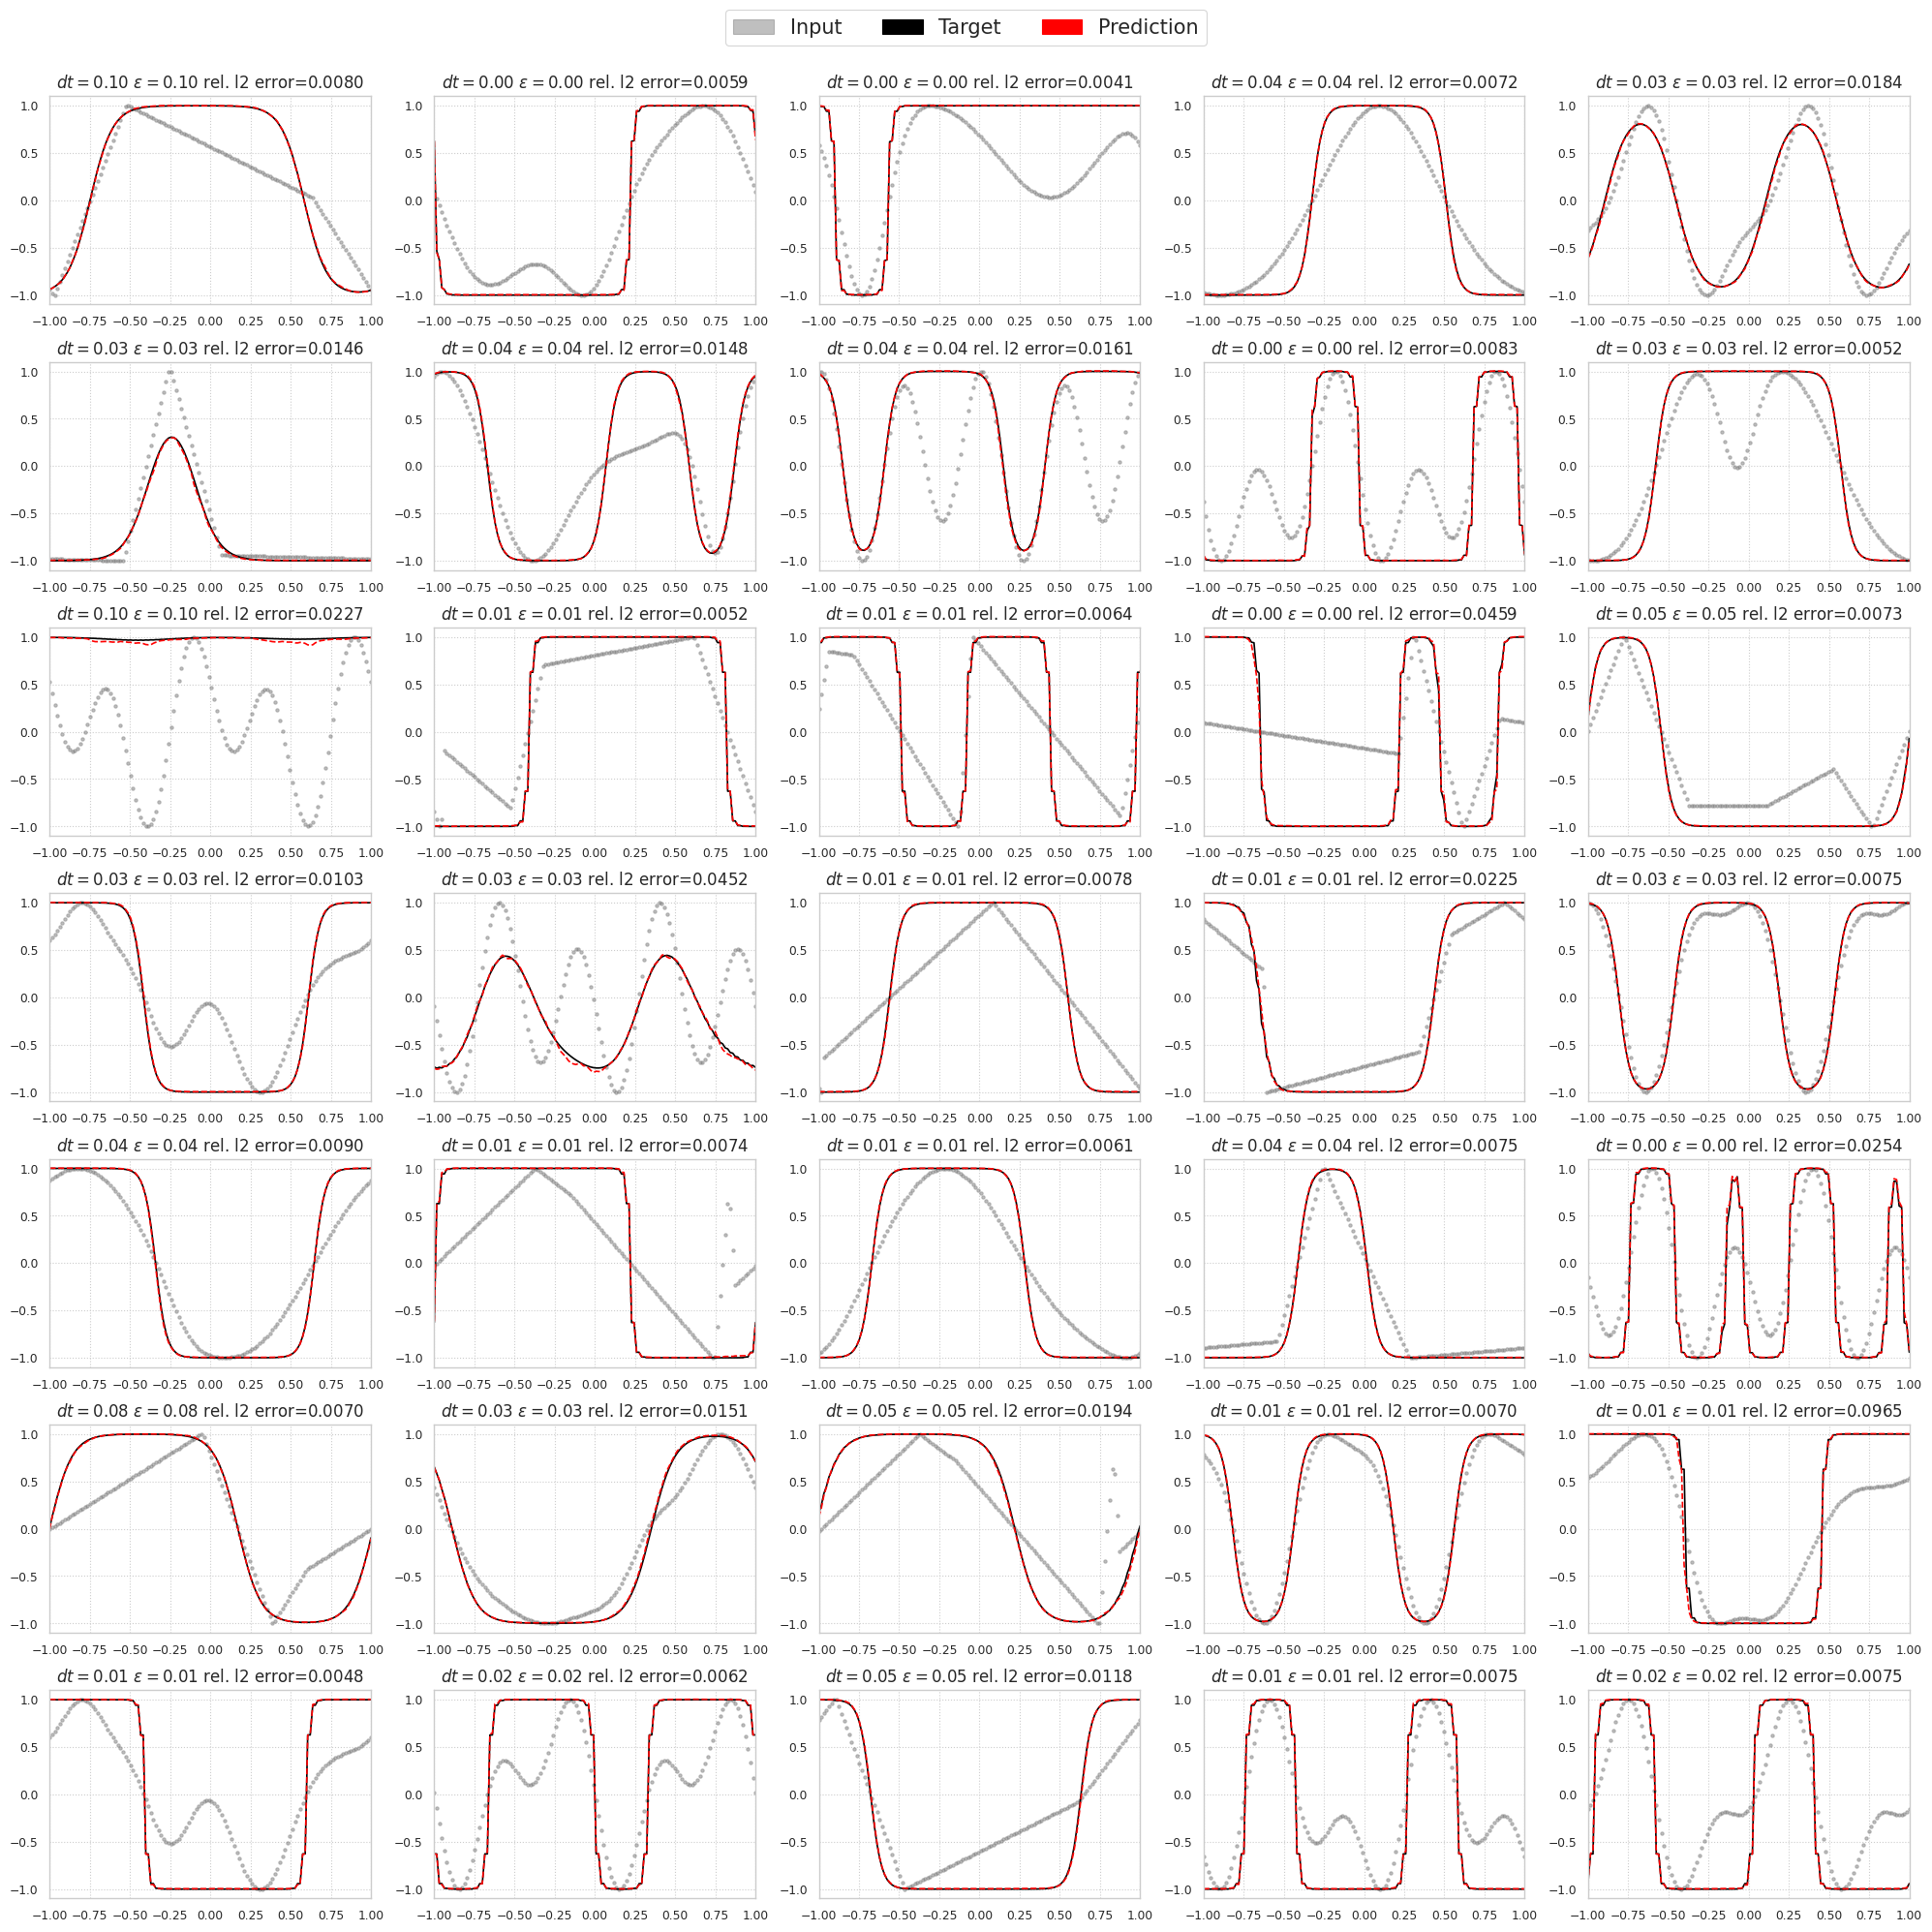

In [78]:
fig, axs = plt.subplots(7, BATCH_SIZE, figsize=(20, 20))

fno.eval()
lines = None
for i, (ax_rows, (time_delta, eps, input, target)) in enumerate(zip(axs, sampler)):
    input_copy = input.clone()

    with torch.no_grad():
        prediction = fno(input, time_delta, eps)

    target = target

    for j, p in enumerate(prediction):
        epsilon = input_copy[j, :, -1][0].item()
        re_l2_error = relative_l2_error(p.squeeze(-1), target[j], dim=-1)

        ax = ax_rows[j]
        # set limits
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1.1, 1.1)

        ax.set_title(
            rf"$dt={time_delta[j].item():.2f}$ $\epsilon={epsilon:.2f}$ rel. l2 error=${re_l2_error:.4f}$",
            fontsize=12,
        )

        x_grid = np.linspace(-1, 1, 128)

        l1 = ax.scatter(
            x_grid,
            input_copy[j, :, 0],
            label="Input",
            alpha=0.5,
            color="gray",
            marker=".",
        )


        l2 = ax.plot(x_grid, target[j], label="Target", color="black")
        l3 = ax.plot(x_grid, p, label="Prediction", color="red", linestyle="--")

        ax.grid(True, which="both", ls=":")

        if i == 0 and j == 0:
            lines = [l1, l2, l3]

labels = [l1.get_label(), l2[0].get_label(), l3[0].get_label()]
handles = []
for group_idx in range(len(labels)):
    # Create a simple patch that is the correct colour
    try:
        colour = lines[group_idx][0].get_color()
        opac = lines[group_idx][0].get_alpha()
    except TypeError:
        colour = lines[group_idx].get_facecolor()
        opac = lines[group_idx].get_alpha()
    handles.append(Patch(edgecolor=colour, facecolor=colour, fill=True, alpha=opac))
# Acutally create our figure legend, using the handles and labels
fig.legend(
    handles=handles, labels=labels, loc="upper center", ncol=len(labels), fontsize=15
)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig("figures/ac_test_examples.png")
plt.show()